Pasos previos:

activar ambiente
tuenvironment\Scripts\activate

pip install --pre torch --index-url https://download.pytorch.org/whl/nightly/cu128

pip install transformers==4.30.0

In [32]:
import torch

# Verificar si CUDA está disponible
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("✅ CUDA disponible. Usando GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("⚠️ CUDA no disponible. Usando CPU.")

✅ CUDA disponible. Usando GPU: NVIDIA GeForce RTX 3070


In [7]:
import kagglehub
import os

# Descargar dataset
path = kagglehub.dataset_download("luthfim/steam-reviews-dataset")
print("Archivos disponibles:", os.listdir(path))

Archivos disponibles: ['steam_reviews.csv']


In [8]:
import pandas as pd

# Cargar CSV con encoding y limpiar nombres de columnas
csv_path = os.path.join(path, "steam_reviews.csv")
df = pd.read_csv(csv_path, encoding="utf-8")
df.columns = df.columns.str.strip()

# Ver columnas
print("Columnas disponibles:", df.columns.tolist())

Columnas disponibles: ['date_posted', 'funny', 'helpful', 'hour_played', 'is_early_access_review', 'recommendation', 'review', 'title']


In [9]:
# Seleccionar y renombrar columnas
df = df[['review', 'recommendation']].copy()
df.rename(columns={'review': 'review_text', 'recommendation': 'recommended'}, inplace=True)

# Convertir a etiquetas binarias
df['label'] = df['recommended'].apply(lambda x: 1 if x == 'Recommended' else 0)

# Filtrar textos nulos o vacíos
df = df[df['review_text'].notnull() & (df['review_text'].str.strip() != '')]

# Balancear clases
min_class = df['label'].value_counts().min()
df_balanced = pd.concat([
    df[df['label'] == 0].sample(min_class, random_state=42),
    df[df['label'] == 1].sample(min_class, random_state=42)
])

print("Distribución balanceada:\n", df_balanced['label'].value_counts())

Distribución balanceada:
 label
0    130624
1    130624
Name: count, dtype: int64


In [10]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_balanced, test_size=0.2, stratify=df_balanced['label'], random_state=42)

In [12]:
from datasets import Dataset
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(example):
    return tokenizer(example["review_text"], truncation=True, padding="max_length", max_length=128)

# Convertir a datasets
train_dataset = Dataset.from_pandas(train_df[['review_text', 'label']])
test_dataset = Dataset.from_pandas(test_df[['review_text', 'label']])

# Aplicar tokenización
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/208998 [00:00<?, ? examples/s]

Map:   0%|          | 0/52250 [00:00<?, ? examples/s]

In [13]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
import evaluate
import numpy as np

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_metric.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1_metric.compute(predictions=preds, references=labels, average="weighted")["f1"]
    }

In [15]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=32,  # Tamaño de lote para entrenamiento
    per_device_eval_batch_size=64,   # Tamaño de lote para evaluación
    num_train_epochs=5,  # Aumentar el número de épocas para entrenar más
    weight_decay=0.01,  # Regularización para evitar sobreajuste
    logging_dir='./logs',
    logging_steps=200,
    save_steps=None,  # No es necesario save_steps cuando no hay evaluación
    save_total_limit=2,
    save_strategy="epoch",  # Guardar después de cada época
    metric_for_best_model="accuracy",  # Métrica para determinar el mejor modelo
    greater_is_better=True,
    no_cuda=not torch.cuda.is_available(),
    fp16=True,  # Usar precisión de 16 bits para acelerar el entrenamiento
    seed=42,  # Semilla para reproducibilidad
    learning_rate=3e-5,  # Ajustar la tasa de aprendizaje para un entrenamiento más eficiente
    warmup_steps=500,  # Calentamiento de pasos para evitar inestabilidad al inicio
)

In [16]:
from transformers import Trainer
import time

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

start = time.time()
trainer.train()
print("⏱ Tiempo total de entrenamiento:", round(time.time() - start, 2), "segundos")

Step,Training Loss
200,0.594400
400,0.396000
600,0.354000
800,0.345400
1000,0.329300
1200,0.314700
1400,0.313900
1600,0.300400
1800,0.286800
2000,0.301800


⏱ Tiempo total de entrenamiento: 2583.01 segundos


In [17]:
results = trainer.evaluate()
print("📊 Resultados finales:", results)

📊 Resultados finales: {'eval_loss': 0.45394834876060486, 'eval_accuracy': 0.8936076555023923, 'eval_f1': 0.89360626341314, 'eval_runtime': 31.5706, 'eval_samples_per_second': 1655.019, 'eval_steps_per_second': 25.878, 'epoch': 5.0}


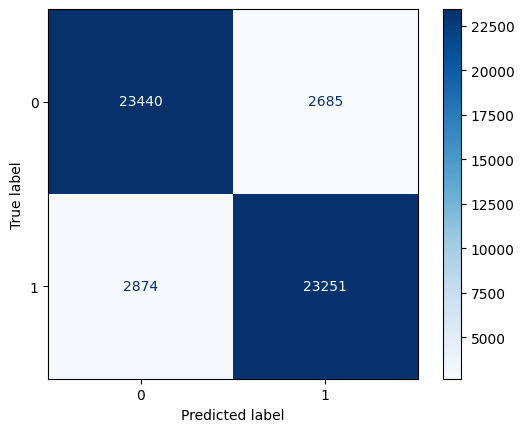

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Primero, hacemos predicciones sobre el set de evaluación
predictions = trainer.predict(trainer.eval_dataset)
preds = np.argmax(predictions.predictions, axis=1)  # Tomamos la clase con mayor probabilidad
labels = predictions.label_ids  # Las etiquetas verdaderas

# Ahora calculamos la matriz de confusión
cm = confusion_matrix(labels, preds)

# Mostramos la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')  # 'd' para que muestre enteros

In [27]:
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)
labels = predictions.label_ids

In [28]:
# Si usaste pandas para armar tu dataset:
df_test = test_dataset.to_pandas()

# Agregamos predicciones
df_test['prediction'] = preds
df_test['label'] = labels


In [29]:
# Aciertos
correct = df_test[df_test['prediction'] == df_test['label']]

# Errores
wrong = df_test[df_test['prediction'] != df_test['label']]

In [31]:
# Mostrar 2 aciertos y 2 errores
ejemplos = pd.concat([
    correct.sample(2, random_state=41),
    wrong.sample(2, random_state=41)
])[['review_text', 'label', 'prediction']]
print(ejemplos)

                                             review_text  label  prediction
6693   One of the worst games you can play right now....      0           0
5710     36$ so i can stare at failed connection screen?      0           0
30194                                              toxic      1           0
28487  This game rocks but overrun with hackers just ...      1           0
